In [1]:
import gzip
import os
import numpy as np
import networkx as nx
from scipy import sparse
from scipy.sparse.linalg import eigs, eigsh
from sklearn.cluster import KMeans
import community as community_louvain
import re
import time
import igraph as ig
import leidenalg as la
import matplotlib.pyplot as plt

# Load Data

Execute only of the cells of the graph you want to study.  
Please notebook first graph clustering methode cannot run on the youtube network. 

---

## Youtube Graph

In [49]:
filename_youtube = "com-youtube.ungraph.txt.gz"
filename_youtube_labels = "com-youtube.all.cmty.txt.gz"
filename_youtube_labels_top5000 = "com-youtube.top5000.cmty.txt.gz"

In [50]:
G = nx.read_edgelist(filename_youtube, create_using=nx.Graph(), nodetype = int)
print(nx.info(G))
print('\nSnap site info: \nNumber of nodes: 1134890 \nNumber of edges: 2987624')

Name: 
Type: Graph
Number of nodes: 1134890
Number of edges: 2987624
Average degree:   5.2650

Snap site info: 
Number of nodes: 1134890 
Number of edges: 2987624


In [51]:
f = gzip.open(filename_youtube_labels, "rb")
file_content = f.read()
f.close()
file_content = file_content.decode("utf-8")

In [52]:
list_str = file_content.split('\n')[:-1]
list_communities = [comu.split('\t') for comu in list_str]
real_communities = [set(comu) for comu in list_communities]

dict_labels = {}
for i in range(len(list_communities)):
    for node in list_communities[i]:
        dict_labels[node] = i

In [53]:
nodelist = list(G.nodes())
nodelist.sort()
mapping = {nodelist[i]: i for i in range(G.number_of_nodes())}
H = nx.relabel_nodes(G, mapping)
G = H.copy()

In [54]:
attributes = {'_nx_name': [i for i in range(len(nodelist))]}
g = ig.Graph(directed=False)
g.add_vertices(len(nodelist), attributes=attributes)
g.add_edges(H.edges())

## Facebook friend cricle network

In [2]:
filename_facebook = "facebook/0.edges"
#filename_facebook = "facebook/107.edges"

In [3]:
G = nx.read_edgelist(filename_facebook, create_using=nx.Graph(), nodetype = int)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 333
Number of edges: 2519
Average degree:  15.1291


In [4]:
is_connected = nx.is_connected(G)
print('Is the graph connected? ',is_connected)
if not is_connected:
    gcc_nodes = max(nx.connected_components(G), key=len)
    G = G.subgraph(gcc_nodes)

nodelist = list(G.nodes())
nodelist.sort()
mapping = {nodelist[i]: i for i in range(G.number_of_nodes())}
H = nx.relabel_nodes(G, mapping)
G = H.copy()
g = ig.Graph.from_networkx(G)

Is the graph connected?  False


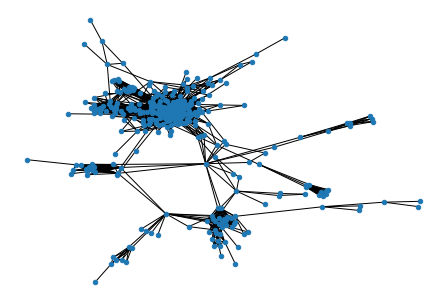

In [5]:
layout = nx.fruchterman_reingold_layout(G)
nx.draw(G, node_size=20, pos = layout)

# Graph characteristics

In [6]:
def compute_network_characteristics(graph):
    prop = {}
    prop['N'] = graph.number_of_nodes() # number of nodes
    prop['M'] = graph.number_of_edges() # number of edges
    #degrees = graph.degree().values()
    degrees = [degree for node, degree in graph.degree()] # degree list
    prop['min_degree'] = np.min(degrees) # minimum degree
    prop['max_degree'] = np.max(degrees) # maximum degree
    prop['mean_degree'] = np.mean(degrees) # mean of node degrees
    prop['median_degree'] = np.median(degrees) # median of node degrees
    prop['density'] = nx.density(graph) # density of the graph
    return prop

###################################################################
prop = compute_network_characteristics(graph=G)
print("Number of nodes: {}".format(prop['N']))
print("Number of edges: {}".format(prop['M']))
print("Min. degree: {}".format(prop['min_degree']))
print("Max. degree: {}".format(prop['max_degree']))
print("Mean degree: {}".format(prop['mean_degree']))
print("Median degree: {}".format(prop['median_degree']))
print("Density: {}".format(prop['density']))

Number of nodes: 324
Number of edges: 2514
Min. degree: 1
Max. degree: 77
Mean degree: 15.518518518518519
Median degree: 10.5
Density: 0.04804494897374154


## Node degree distribution
Let's compute the node degree distribution and plot it in log-log scale

In [7]:
graph_degrees = list(dict(G.degree()).values())
unique, counts = np.unique(graph_degrees, return_counts=True)

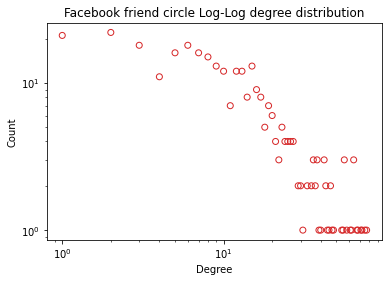

In [8]:
plt.scatter(unique, counts, facecolors='none', edgecolors='tab:red')
plt.yscale('log')
plt.xscale('log')
plt.title('Facebook friend circle Log-Log degree distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
#plt.savefig('facebook_degree.jpg')
plt.show()

In [9]:
a,b = np.polyfit(np.log(unique), np.log(counts), 1)
print(f'{a} x + {b}')

-0.9802491089164225 x + 4.315015944795777


## Clustering coefficient

In [179]:
graph_degrees = list(dict(G.degree()).values())
unique, counts = np.unique(graph_degrees, return_counts=True)
node_degree = sorted(dict(G.degree()).items(), key=lambda x: x[1])

clustering_list = []
cumsum_counts = np.cumsum(counts)
for i in range(len(cumsum_counts)):
    if i != 0:
        nodelist = dict(node_degree[cumsum_counts[i-1]:cumsum_counts[i]]).keys()
    else:
        nodelist = dict(node_degree[:cumsum_counts[0]]).keys()
    
    clust = np.mean(list(nx.clustering(G, nodelist).values()))
    clustering_list.append(clust)

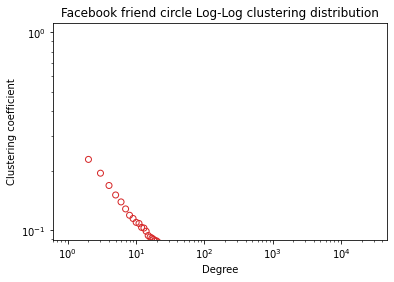

In [180]:
plt.scatter(unique, clustering_list, facecolors='none', edgecolors='tab:red')
plt.yscale('log')
plt.xscale('log')
plt.title('Facebook friend circle Log-Log clustering distribution')
plt.xlabel('Degree')
plt.ylabel('Clustering coefficient')
#plt.savefig('facebook_degree.jpg')
plt.show()

# Evaluation metrics
Given G(V,E) an undirected graph, let $n = |V|$ be the number of nodes and $m = |E|$ the number of edges in the graph. Let also $k_i$ be the degree of node $i$ in G and A be the adjacency matrix of the graph. Given S a set of nodes in the graph G, let $n_S = |S|$ be the number of nodes in S, $m_S = |\{(u,v) \in E : u \in S, v \in S\}|$ the number of edges in S, $b_S = |\{(u,v) \in E : u \in S, v \notin S\}|$ the number of edges on the boundary of S.

We will also denote $\mathcal{V} = \{S_1, S_2, S_3,...,S_k\}$ a partition of the graph where $S_i, i \in \{1,2,...,k\}$ will be called communities. For a given partition $\mathcal{V}$ we can define $q = \frac{\sum_i^k m_{S_i}}{m}$ the relative number of internal edges and $\langle q \rangle = \frac{\sum_i^k \binom{n_{S_i}}{2}}{\binom{n}{2}}$ the relative number of expected internal edges.


Separability:  
$Sep(S) = \frac{m_S}{b_S}$

Clustering Coefficient:  
$C(S) = \frac{1}{n_S} \sum_{i \in S} C_i \text{,  where } 
C_{i} = \frac{2 e_{i}}{k_i (k_i - 1)}$

Density:  
$D(S) = \frac{2 m_S}{n_S (n_S - 1)}$


In [27]:
def separability_density_clustering(G, partition):
    G_test = G.copy()
    num_edges_tot = G_test.number_of_edges()
    list_separability = []
    list_density = []
    list_clustering = []
    
    for community in partition:
        commnity_graph = G_test.subgraph(community)
        
        ms = commnity_graph.number_of_edges()
        cs = len(list(nx.edge_boundary(G_test, community)))
            
        separability = ms / cs
        density = nx.density(commnity_graph)
        clustering = np.mean(list(nx.clustering(G_test, community).values()))
        
        list_separability.append(separability)
        list_density.append(density)
        list_clustering.append(clustering)
        
    return list_separability, list_density, list_clustering

# Algorithms

*   Girvan Newman
*   Spectral Clustering
*   Modularity Optimization
*   Walktrap
*   Louvain
*   Leiden

The 4 first algorithms are only usable for the facebook graph for computing time reasons.

## Girvan Newman

In [506]:
# Exercise 1.1
def girvan_newman_algorithm(G):
    '''
    :param G: given graph
    :return partitions: a list tuples of sets of nodes in the graph. Each node set indicates a community and
    each tuple is a sequence of communities at a certain level of the algorithm.
    '''
    g = G.copy()
    partitions = []
    size=1
    
    # Repeat below process until one edge left
    while len(g.edges) > 0:
        
        # Compute betweeness centrality for every edges - use shortest path 
        ebc = nx.edge_betweenness_centrality(g)
    
        # Remove edge with highest centrality
        edge = max(ebc, key=ebc.get)
        g.remove_edge(edge[0], edge[1]) 
    
        # Retrieve communities with this edge removal
        # communities = [c for c in sorted(nx.connected_components(g), key=len, reverse=True)]
        communities = list(nx.connected_components(g))
        
        # Update partitions if communities have changed
        if len(communities) != size: 
            partitions.append(communities)
            size += 1
        
    # Use below dendograms to learn when to stop 
    return partitions

def plot_dendrogram(G, partitions):

    num_of_nodes = G.number_of_nodes()
    dist = np.ones( shape=(num_of_nodes, num_of_nodes), dtype=np.float )*num_of_nodes
    d = num_of_nodes-1
    for partition in partitions:
        for subset in partition:
            for i in range(len(subset)):
                for j in range(i+1, len(subset)):
                    subsetl = list(subset)

                    dist[int(subsetl[i]), int(subsetl[j])] = d
                    dist[int(subsetl[j]), int(subsetl[i])] = d
        d -= 1



    dist_list = [dist[i,j] for i in range(num_of_nodes) for j in range(i+1, num_of_nodes)]


    Z = hierarchy.linkage(dist_list, 'complete')
    plt.figure()
    dn = hierarchy.dendrogram(Z)

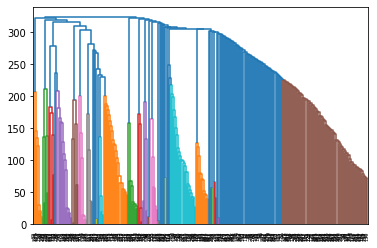

In [507]:
partitions_girvan = girvan_newman_algorithm(G)
plot_dendrogram(G, partitions_girvan)

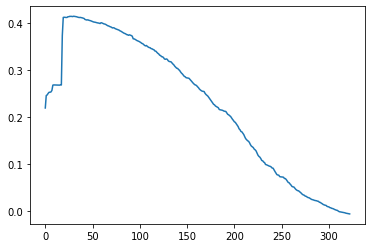

Optimal number of communities 31


In [508]:
modularity_girvan = []
for i in range(len(partitions_girvan)):
    modularity = nx.algorithms.community.quality.modularity(G, partitions_girvan[i])
    modularity_girvan.append(modularity)

plt.plot(modularity_girvan)
plt.show()

print(f'Optimal number of communities {np.argmax(modularity_girvan) + 1}')

In [509]:
best_partition = np.argmax(modularity_girvan)
number_of_communities = len(partitions_girvan[best_partition])
communities = partitions_girvan[best_partition]
    
separability, density, clustering = separability_density_clustering(G, communities)
modularity = modularity_girvan[best_partition]
print(f'Modularity separability: mean -> {round(np.mean(separability),2)}; std -> {round(np.std(separability),2)}')
print(f'Modularity clustering: mean -> {round(np.mean(clustering),2)}; std -> {round(np.std(clustering),2)}')
print(f'Modularity density: mean -> {round(np.mean(density),2)}; std -> {round(np.std(density),2)}')
print(f'Modularity modularity -> {round(modularity,2)}')

Modularity separability: mean -> 3.48; std -> 7.75
Modularity clustering: mean -> 0.39; std -> 0.35
Modularity density: mean -> 0.39; std -> 0.4
Modularity modularity -> 0.41


In [510]:
best_girvan_partition = partitions_girvan[np.argmax(modularity_girvan)]

## Spectral Clustering

In [511]:
# Exercise 1.1
def spectral_clustering(G, k, normalized_cut = True):
    '''
    :param G: given graph
    :param k: the number of clusters
    :return partition: a list of node sets where each node set indicates a cluster
    '''
    # For a given undirected connected graph
    
    nodelist = list(G)  # keep the node orders
    A = np.array(nx.adjacency_matrix(G, nodelist).todense())
    D = np.diag(np.sum(A, axis=1))
    L = D - A # Laplacian matrix
    if normalized_cut:
        L = np.linalg.inv(D) @ L # Normalized Cut
    
    eigvals, eigvects = np.linalg.eigh(L)
    # Sort the eigenvectors corresponding to their eigenvalues
    idx = np.argsort(eigvals)
    # eigvals = eigvals[idx]
    eigvects = eigvects[:,idx]
    
    # Retrieve top k eigenvectors wrt eigenvalue
    X = eigvects[:, 0:k]
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    
    partition = [set() for _ in range(k)]
    for i in range(len(nodelist)):
        partition[kmeans.labels_[i]].add(nodelist[i])
            
    return partition


def spectral_clustering_exploration(G, normalized_cut = True):
    '''
    :param G: given graph
    :param k: the number of clusters
    :return partition: a list of node sets where each node set indicates a cluster
    '''
    # For a given undirected connected graph
    
    nodelist = list(G)  # keep the node orders
    A = np.array(nx.adjacency_matrix(G, nodelist).todense())
    D = np.diag(np.sum(A, axis=1))
    L = D - A # Laplacian matrix
    if normalized_cut:
        L = np.linalg.inv(D) @ L # Normalized Cut
    
    eigvals, eigvects = np.linalg.eigh(L)
    # Sort the eigenvectors corresponding to their eigenvalues
    idx = np.argsort(eigvals)
    # eigvals = eigvals[idx]
    eigvects = eigvects[:,idx]
    
    # Retrieve top k eigenvectors wrt eigenvalue
    all_partitions = []
    for k in range(1, len(nodelist) + 1):
        X = eigvects[:, 0:k]
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
    
        partition = [set() for _ in range(k)]
        for i in range(len(nodelist)):
            partition[kmeans.labels_[i]].add(nodelist[i])
            
        all_partitions.append(partition)
            
    return all_partitions

In [63]:
partition = spectral_clustering(G, k=42, normalized_cut=True)

In [78]:
number_of_communities = len(partition)
print(f'Spectral clustering (Normalized laplacian) methode detected << {number_of_communities} >> communities')

Spectral clustering (Normalized laplacian) methode detected << 42 >> communities


In [512]:
partitions_spectral = spectral_clustering_exploration(G, True)

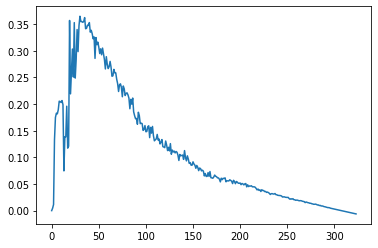

Optimal number of communities 31


In [513]:
modularity_spectral = []
for i in range(len(partitions_spectral)):
    modularity = nx.algorithms.community.quality.modularity(G, partitions_spectral[i])
    modularity_spectral.append(modularity)

plt.plot(modularity_spectral)
plt.show()

print(f'Optimal number of communities {np.argmax(modularity_spectral) + 1}')

In [514]:
best_partition = np.argmax(modularity_spectral)
number_of_communities = len(partitions_spectral[best_partition])
communities = partitions_spectral[best_partition]
#communities = [set() for _ in range(number_of_communities)]
#for node in partition_louvain.items():
#    communities[node[1]].add(node[0])
    
separability, density, clustering = separability_density_clustering(G, communities)
modularity = nx.algorithms.community.quality.modularity(G, communities)
print(f'Spectral normalized separability: mean -> {round(np.mean(separability),2)}; std -> {round(np.std(separability),2)}')
print(f'Spectral normalized clustering: mean -> {round(np.mean(clustering),2)}; std -> {round(np.std(clustering),2)}')
print(f'Spectral normalized density: mean -> {round(np.mean(density),2)}; std -> {round(np.std(density),2)}')
print(f'Spectral normalized modularity -> {round(modularity,2)}')

Spectral normalized separability: mean -> 2.19; std -> 6.96
Spectral normalized clustering: mean -> 0.37; std -> 0.27
Spectral normalized density: mean -> 0.76; std -> 0.25
Spectral normalized modularity -> 0.37


In [515]:
best_spectral_partition = partitions_spectral[np.argmax(modularity_spectral)]

## Modularity optimization

In [23]:
def modularity_clustering(G, k):
    
    nodelist = list(G)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    dict_degree = dict(G.degree())
    
    degree_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            degree_matrix[i,j] = dict_degree[i] * dict_degree[j] / (2 * num_edges)
    
    A = np.array(nx.adjacency_matrix(G, nodelist).todense())
    B = (A - degree_matrix) / (2 * num_edges)
    
    eigvals, eigvects = np.linalg.eigh(B)
    idx = np.argsort(eigvals)
    idx = idx[::-1]
    
    eigvects = eigvects[:,idx]
    X = eigvects[:, 0:k]
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    
    partition = [set() for _ in range(k)]
    for i in range(len(nodelist)):
        partition[kmeans.labels_[i]].add(nodelist[i])
    
    return partition

def modularity_clustering_exploration(G):
    
    nodelist = list(G)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    dict_degree = dict(G.degree())
    
    degree_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            degree_matrix[i,j] = dict_degree[i] * dict_degree[j] / (2 * num_edges)
    
    A = np.array(nx.adjacency_matrix(G, nodelist).todense())
    B = (A - degree_matrix) / (2 * num_edges)
    
    eigvals, eigvects = np.linalg.eigh(B)
    idx = np.argsort(eigvals)
    idx = idx[::-1]
    
    eigvects = eigvects[:,idx]
    
    all_partitions = []
    for k in range(1, len(nodelist) + 1):
        X = eigvects[:, 0:k]

        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)

        partition = [set() for _ in range(k)]
        for i in range(len(nodelist)):
            partition[kmeans.labels_[i]].add(nodelist[i])
            
        all_partitions.append(partition)
    
    return all_partitions

In [80]:
partition = modularity_clustering(G, k=42)

In [81]:
number_of_communities = len(partition)
print(f'Modularity optimization methode detected << {number_of_communities} >> communities')

Modularity optimization methode detected << 42 >> communities


In [24]:
partitions_mod = modularity_clustering_exploration(G)

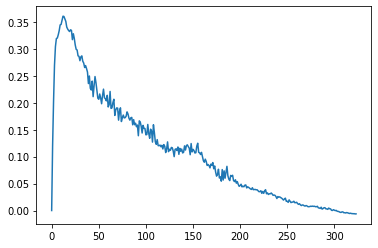

Optimal number of communities 13


In [25]:
modularity_mod = []
for i in range(len(partitions_mod)):
    modularity = nx.algorithms.community.quality.modularity(G, partitions_mod[i])
    modularity_mod.append(modularity)

plt.plot(modularity_mod)
plt.show()

print(f'Optimal number of communities {np.argmax(modularity_mod) + 1}')

In [28]:
best_partition = np.argmax(modularity_mod)
number_of_communities = len(partitions_mod[best_partition])
communities = partitions_mod[best_partition]
    
separability, density, clustering = separability_density_clustering(G, communities)
modularity = nx.algorithms.community.quality.modularity(G, communities)
print(f'Modularity separability: mean -> {round(np.mean(separability),2)}; std -> {round(np.std(separability),2)}')
print(f'Modularity clustering: mean -> {round(np.mean(clustering),2)}; std -> {round(np.std(clustering),2)}')
print(f'Modularity density: mean -> {round(np.mean(density),2)}; std -> {round(np.std(density),2)}')
print(f'Modularity modularity -> {round(modularity,2)}')

Modularity separability: mean -> 1.84; std -> 3.1
Modularity clustering: mean -> 0.59; std -> 0.14
Modularity density: mean -> 0.58; std -> 0.26
Modularity modularity -> 0.36


In [520]:
best_mod_partition = partitions_mod[np.argmax(modularity_mod)]

### Compare all three models above

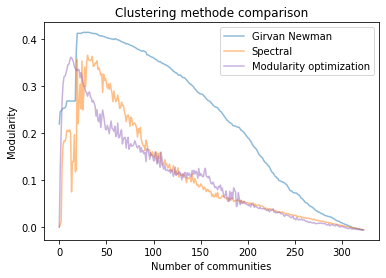

Girvan opimal number of clusters ->  31
Spectral opimal number of clusters ->  31
Modularity opimal number of clusters ->  13


In [521]:
plt.plot(modularity_girvan, alpha=0.5, color='tab:blue', label='Girvan Newman')
plt.plot(modularity_spectral, alpha=0.5, color='tab:orange', label='Spectral')
plt.plot(modularity_mod, alpha=0.5, color='tab:purple', label='Modularity optimization')
plt.title('Clustering methode comparison')
plt.xlabel('Number of communities')
plt.ylabel('Modularity')
plt.legend()
#plt.savefig('clustering_methode_comparison.jpg')
plt.show()

print('Girvan opimal number of clusters -> ',np.argmax(modularity_girvan)+1)
print('Spectral opimal number of clusters -> ',np.argmax(modularity_spectral)+1)
print('Modularity opimal number of clusters -> ',np.argmax(modularity_mod)+1)

In [525]:
# Girvan Newman
girvan_community_size = []
for sub_partition in best_girvan_partition:
    girvan_community_size.append(len(sub_partition))

unique_girvan, counts_girvan = np.unique(girvan_community_size, return_counts=True)

# Spectral
spectral_community_size = []
for sub_partition in best_spectral_partition:
    spectral_community_size.append(len(sub_partition))
    
unique_spectral, counts_spectral = np.unique(spectral_community_size, return_counts=True)
    
# Modularity optimization
mod_community_size = []
for sub_partition in best_mod_partition:
    mod_community_size.append(len(sub_partition))
    
unique_mod, counts_mod = np.unique(mod_community_size, return_counts=True)

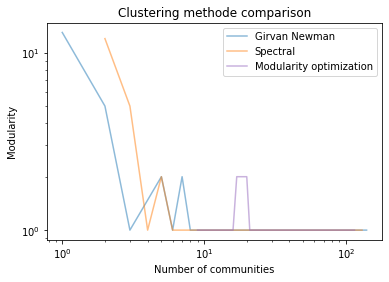

In [529]:
plt.plot(unique_girvan, counts_girvan, alpha=0.5, color='tab:blue', label='Girvan Newman')
plt.plot(unique_spectral, counts_spectral, alpha=0.5, color='tab:orange', label='Spectral')
plt.plot(unique_mod, counts_mod, alpha=0.5, color='tab:purple', label='Modularity optimization')
plt.xscale('log')
plt.yscale('log')
plt.title('Clustering methode comparison')
plt.xlabel('Number of communities')
plt.ylabel('Modularity')
plt.legend()
#plt.savefig('clustering_methode_comparison.jpg')
plt.show()

## Walktrap

In [19]:
step = 8
com_WT = g.community_walktrap(steps=step).as_clustering()

In [20]:
print("Modularity of Walktrap partition:", com_WT.modularity)

Modularity of Walktrap partition: 0.39544010976874777


In [21]:
print("number of communities detected:", len(list(com_WT)))

number of communities detected: 26


In [22]:
A = g.get_edgelist()
g_nx = nx.Graph(A)

In [10]:
ig.plot(com_WT)

## Louvain methode

In [69]:
partition_louvain = community_louvain.best_partition(G, random_state=0)
number_of_communities = len(set(partition_louvain.values()))
print(f'Louvain methode detected << {number_of_communities} >> communities')

Louvain methode detected << 10 >> communities


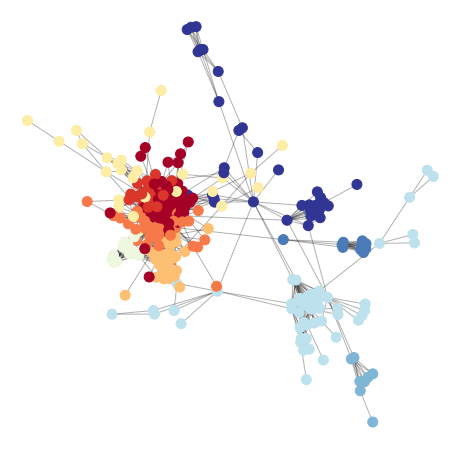

In [70]:
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.RdYlBu, node_color=list(partition_louvain.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show(G)

In [38]:
number_of_communities = len(set(partition_louvain.values()))
communities = [set() for _ in range(number_of_communities)]
for node in partition_louvain.items():
    communities[node[1]].add(node[0])
    
separability_louvain, density_louvain, clustering_louvain = separability_density_clustering(G, communities)
modularity = nx.algorithms.community.quality.modularity(G, communities)
print(f'Louvain separability: mean -> {round(np.mean(separability_louvain),2)}; std -> {round(np.std(separability_louvain),2)}')
print(f'Louvain clustering: mean -> {round(np.mean(clustering_louvain),2)}; std -> {round(np.std(clustering_louvain),2)}')
print(f'Louvain density: mean -> {round(np.mean(density_louvain),2)}; std -> {round(np.std(density_louvain),2)}')
print(f'Louvain modularity -> {round(modularity,2)}')

Louvain separability: mean -> 4.41; std -> 4.8
Louvain clustering: mean -> 0.08; std -> 0.17
Louvain density: mean -> 0.41; std -> 0.2
Louvain modularity -> 0.72


## Leiden methode

In [60]:
partition_leiden = la.find_partition(g, la.ModularityVertexPartition, n_iterations=10, seed = 0)
membership_list = partition_leiden.membership
print(f'Leiden methode detected << {len(set(membership_list))} >> communities')
print(f'Modularity -> {partition_leiden.modularity}')

Leiden methode detected << 10 >> communities
Modularity -> 0.46206454673241143


In [61]:
number_of_communities = len(set(partition_leiden.membership))
communities = [set(commu.vs()['_nx_name']) for commu in partition_leiden.subgraphs()]
#communities = [set() for _ in range(number_of_communities)]
#partition_leiden.subgraphs()[0].vs()['_nx_name']
#for node, label in enumerate(partition_leiden.membership):
#    communities[label].add(node)
    
separability, density, clustering = separability_density_clustering(G, communities)
modularity = partition_leiden.modularity
print(f'Leiden separability: mean -> {round(np.mean(separability),2)}; std -> {round(np.std(separability),2)}')
print(f'Leiden clustering: mean -> {round(np.mean(clustering),2)}; std -> {round(np.std(clustering),2)}')
print(f'Leiden density: mean -> {round(np.mean(density),2)}; std -> {round(np.std(density),2)}')
print(f'Leiden modularity -> {round(modularity,2)}')

Leiden separability: mean -> 8.44; std -> 12.45
Leiden clustering: mean -> 0.57; std -> 0.16
Leiden density: mean -> 0.41; std -> 0.27
Leiden modularity -> 0.46


### Show communities

In [72]:
dict_label = {}
for i, commu in enumerate(communities):
    for node in commu:
        dict_label[node] = i
dict_label = dict(sorted(dict_label.items(), key=lambda x: x[0]))

L = []
for node in G.nodes():
    L.append(dict_label[node])

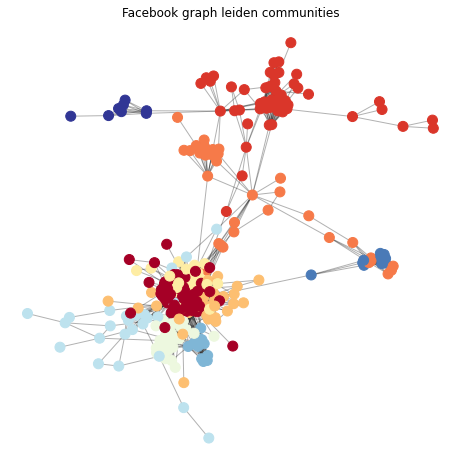

In [75]:
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.RdYlBu, node_color=L)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('Facebook graph leiden communities')
plt.savefig('facebook_leiden_communities.jpg')
plt.show(G)

### Metric repartitions

In [450]:
unique, counts = np.unique(membership_list, return_counts=True)
unique, counts = np.unique(counts, return_counts=True)

In [500]:
def show_metric_vs_comm_size(communities, metric, title, x_label, y_label, x_log=True, y_log=True, color='tab:red', save=False):
    community_size = [len(communities[i]) for i in range(len(communities))]
    unique, counts = np.unique(community_size, return_counts=True)
    metric_dict = {unique[i]: 0 for i in range(len(unique))}

    for i in range(len(metric)):
        metric_dict[community_size[i]] += metric[i]

    for i in range(len(unique)):
        metric_dict[unique[i]] /= counts[i]

    plt.scatter(list(metric_dict.keys()), list(metric_dict.values()), facecolors='none', edgecolors=color)
    if y_log:
        plt.yscale('log')
    if x_log:
        plt.xscale('log')
    #plt.xlim((1,4000))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if save:
        plt.savefig('_'.join(title.lower().split(' ')) + '.jpg')
    plt.show()

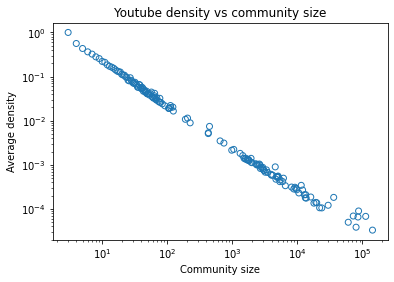

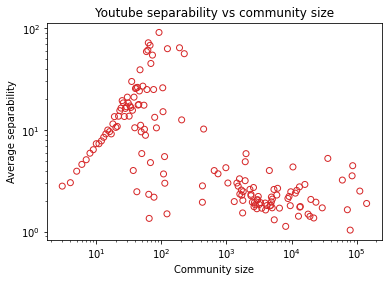

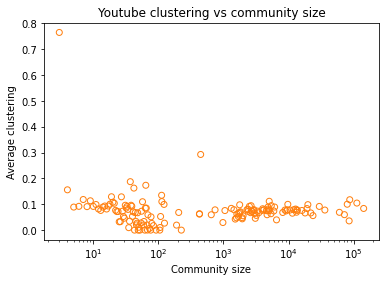

In [501]:
show_metric_vs_comm_size(communities, density, title = 'Youtube density vs community size', x_label = 'Community size', y_label = 'Average density', color='tab:blue', save=True)
show_metric_vs_comm_size(communities, separability, title = 'Youtube separability vs community size', x_label = 'Community size', y_label = 'Average separability', save=True)
show_metric_vs_comm_size(communities, clustering, title = 'Youtube clustering vs community size', x_label = 'Community size', y_label = 'Average clustering', y_log=False, color='tab:orange', save=True)

In [48]:
# Density power law parameters

community_size = [len(communities[i]) for i in range(len(communities))]
unique, counts = np.unique(community_size, return_counts=True)
metric_dict = {unique[i]: 0 for i in range(len(unique))}

for i in range(len(density)):
    metric_dict[community_size[i]] += density[i]

for i in range(len(unique)):
    metric_dict[unique[i]] /= counts[i]

a,b = np.polyfit(np.log(unique), np.log(counts), 1)
print(f'{round(a,2)} x + {round(b,2)}')

-0.4 x + 3.3


### Metric repartition study

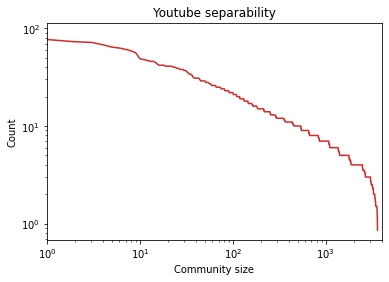

In [465]:
test_sep = separability.copy()
test_sep.sort()
test_sep = test_sep[::-1]

plt.plot(range(len(test_sep)), test_sep, c='tab:red')
plt.yscale('log')
plt.xscale('log')
plt.xlim((1,4000))
plt.title('Youtube separability')
plt.xlabel('Community size')
plt.ylabel('Count')
#plt.savefig('facebook_degree.jpg')
plt.show()

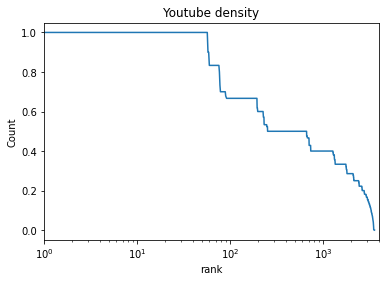

In [471]:
test_density = density.copy()
test_density.sort()
test_density = test_density[::-1]

plt.plot(range(len(test_density)), test_density, c='tab:blue')
#plt.yscale('log')
plt.xscale('log')
plt.xlim((1,4000))
plt.title('Youtube density')
plt.xlabel('rank')
plt.ylabel('Count')
#plt.savefig('facebook_degree.jpg')
plt.show()

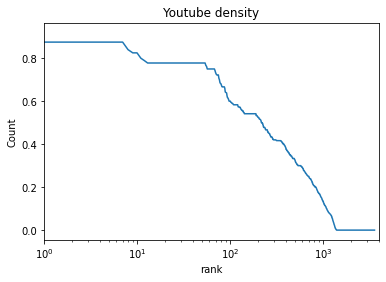

In [472]:
test_clust = clustering.copy()
test_clust.sort()
test_clust = test_clust[::-1]

plt.plot(range(len(test_clust)), test_clust, c='tab:blue')
#plt.yscale('log')
plt.xscale('log')
plt.xlim((1,4000))
plt.title('Youtube clustering')
plt.xlabel('rank')
plt.ylabel('Count')
#plt.savefig('facebook_degree.jpg')
plt.show()

### Modularity evolution with iterations

In [14]:
modularity_evolution = []
computing_time = []
for iterations in range(1, 11):
    start = time.time() # record time
    partition = la.find_partition(g, la.ModularityVertexPartition, n_iterations = iterations, seed = 0)
    end = time.time()

    modularity_evolution.append(partition.modularity)
    computing_time.append(end - start)
    print(f'iteration [{iterations}] completed')

iteration [1] completed
iteration [2] completed
iteration [3] completed
iteration [4] completed
iteration [5] completed
iteration [6] completed
iteration [7] completed
iteration [8] completed
iteration [9] completed
iteration [10] completed


In [117]:
surprise_evolution = []
computing_time_surprise = []
for iterations in range(1, 11):
    start = time.time() # record time
    partition = la.find_partition(g, la.SurpriseVertexPartition, n_iterations = iterations, seed = 0)
    end = time.time()

    surprise_evolution.append(partition.modularity)
    computing_time_surprise.append(end - start)
    print(f'iteration [{iterations}] completed')

iteration [1] completed
iteration [2] completed
iteration [3] completed
iteration [4] completed
iteration [5] completed
iteration [6] completed
iteration [7] completed
iteration [8] completed
iteration [9] completed
iteration [10] completed


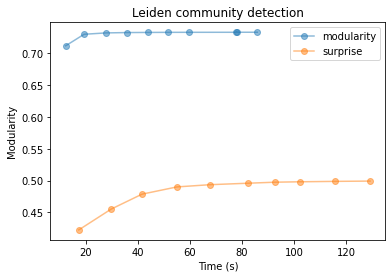

In [119]:
plt.plot(computing_time, modularity_evolution, 'o-', color='tab:blue', label='modularity', alpha=0.5)
plt.plot(computing_time_surprise, surprise_evolution, 'o-', color='tab:orange', label='surprise', alpha=0.5)
plt.title('Leiden community detection')
plt.xlabel('Time (s)')
plt.ylabel('Modularity')
plt.legend()
plt.savefig('leiden_modularity_suprise_iteration_youtube_dataset.jpg')
plt.show()